In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from scipy import stats
from scipy.stats import rayleigh, circmean, circvar, circstd, circvar
# from scipy.stats import watson

import os

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [5]:
def readData():
    resource = 'resources/'
    data = pd.read_csv(resource+'prob2.csv', sep=' ', header=None)
    data.columns = ['azimuth', 'zenith']
    return data
data = readData()

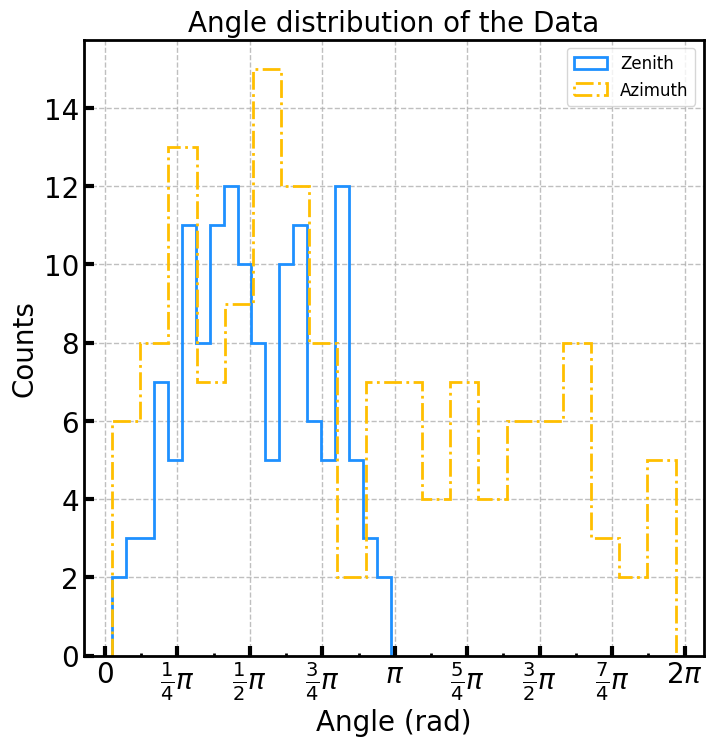

In [6]:
def plotData(data):
    Nbin = 20
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.hist(data['zenith'], bins=Nbin, histtype='step', label='Zenith', lw = 2)
    ax.hist(data['azimuth'], bins=Nbin, histtype='step', label='Azimuth', lw = 2)
    ax.set_xlabel('Angle (rad)')
    ax.set_ylabel('Counts')
    ax.set_title('Angle distribution of the Data')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=np.pi / 4))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=np.pi / 8))
    ax.legend()

    def format_func(value, tick_number):
        N = int(np.round(value / np.pi * 4))
        if N == 0:
            return "0"
        elif N == 4:
            return r"$\pi$"
        elif N == 8:
            return r"$2\pi$"
        elif N % 4 == 0:
            return r"${0}\pi$".format(N // 4)
        elif N % 2 == 0:
            return r"$\frac{{{0}}}{{2}}\pi$".format(N // 2)
        else:
            return r"$\frac{{{0}}}{{4}}\pi$".format(N)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plotData(data)

In [7]:
def generateNull():
    np.random.seed(75)
    N = 10000
    zenith = np.arccos(np.random.uniform(-1, 1, N))
    azimuth = np.random.uniform(0, 2*np.pi, N)
    return zenith, azimuth
zenith0, azimuth0 = generateNull()

In [8]:
def KSTest(data, pseudo_data):
    ks, p = stats.ks_2samp(data, pseudo_data, method = 'exact')
    print(f"K-S Test: {ks:.4f}, p: {p:.4f}")
    return ks, p

In [9]:
def plotHisto(zenith, azimuth, title):
    Nbin = 20
    ks_z, p_z = KSTest(data['zenith'], zenith)
    ks_a, p_a = KSTest(data['azimuth'], azimuth)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.hist(zenith, bins=Nbin, histtype='step', linewidth=2, label='Zenith '+title, density=True)
    ax.hist(data['zenith'], bins=Nbin, histtype='step', linewidth=2, label='Zenith Data', linestyle='--', density=True)
    ax.hist(azimuth, bins=Nbin, histtype='step', linewidth=2, label='Azimuth '+title, linestyle='-', density=True)
    ax.hist(data['azimuth'], bins=Nbin, histtype='step', linewidth=2, label='Azimuth Data', linestyle='--', density=True)
    ax.set_xlabel('Angle [rad]')
    ax.set_ylabel('Counts')
    ax.set_title('Angle Distribution of Hypothesis '+title+' and Data')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=np.pi / 4))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=np.pi / 8))
    ax.legend()

    def format_func(value, tick_number):
        N = int(np.round(value / np.pi * 4))
        if N == 0:
            return "0"
        elif N == 4:
            return r"$\pi$"
        elif N == 8:
            return r"$2\pi$"
        elif N % 4 == 0:
            return r"${0}\pi$".format(N // 4)
        elif N % 2 == 0:
            return r"$\frac{{{0}}}{{2}}\pi$".format(N // 2)
        else:
            return r"$\frac{{{0}}}{{4}}\pi$".format(N)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    d = {
        'N': len(zenith),
        'N data' : len(data['zenith']),
        'N bin' : Nbin,
        }
    d_z = {
        'Zenith': '',
        'K-S Test': ks_z, 
        'p-value': p_z,
        }
    d_a = {
        'Azimuth': '',
        'K-S Test': ks_a, 
        'p-value': p_a,
        }
    text = nice_string_output(d)
    text_z = nice_string_output(d_z)
    text_a = nice_string_output(d_a)

    x0 = 0.7
    y0 = 0.75
    y1 = y0 - 0.15
    y2 = y1 - 0.15
    add_text_to_ax(x0, y0, text, ax, fontsize=12)
    add_text_to_ax(x0, y1, text_z, ax, fontsize=12)
    add_text_to_ax(x0, y2, text_a, ax, fontsize=12)
    

K-S Test: 0.0580, p: 0.7236
K-S Test: 0.1725, p: 0.0005


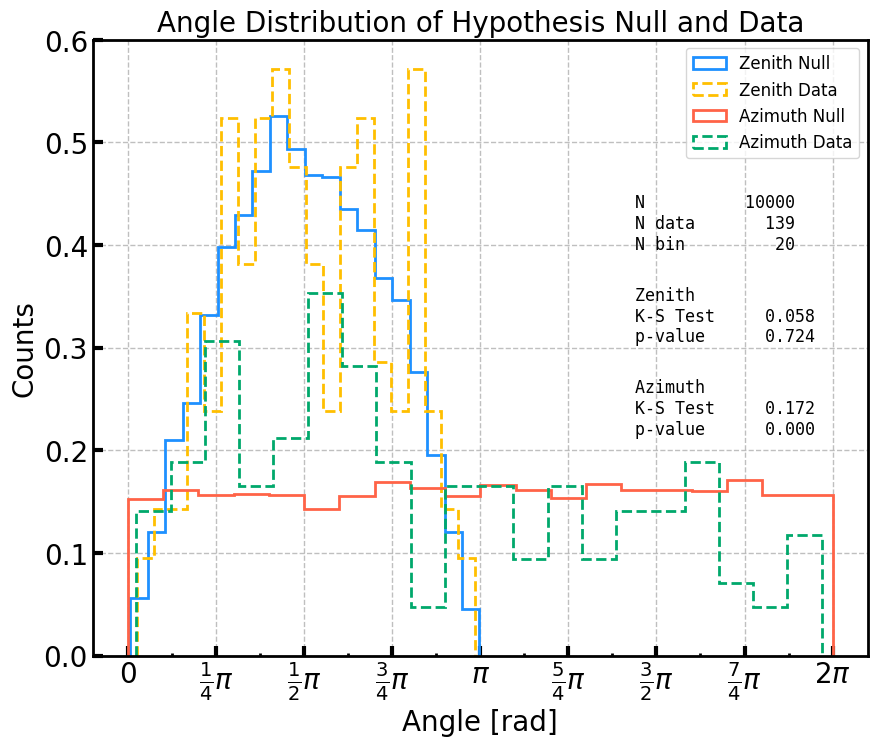

In [10]:
plotHisto(zenith0, azimuth0, 'Null')

In [11]:
def generateHypothesis(fraction, rangeAzimuth, rangeZenith):
    N = 10000
    N_anisotropic = int(N * fraction)
    N_isotropic = N - N_anisotropic
    
    azimuth_anisotropic = np.random.uniform(np.pi*rangeAzimuth[0], np.pi*rangeAzimuth[1], N_anisotropic)
    cos_zenith_anisotropic = np.random.uniform(np.cos(np.pi*rangeZenith[1]), np.cos(np.pi*rangeZenith[0]), N_anisotropic)
    zenith_anisotropic = np.arccos(cos_zenith_anisotropic)
    
    azimuth_isotropic = np.random.uniform(0, 2*np.pi, N_isotropic)
    cos_zenith_isotropic = np.random.uniform(-1, 1, N_isotropic)
    zenith_isotropic = np.arccos(cos_zenith_isotropic)
    
    zenith = np.concatenate([zenith_anisotropic, zenith_isotropic])
    azimuth = np.concatenate([azimuth_anisotropic, azimuth_isotropic])
    
    return zenith, azimuth

In [12]:
zenith1, azimuth1 = generateHypothesis(0.20, [0.225, 0.725], [0.30, 1.0])
zenith2, azimuth2 = generateHypothesis(0.15, [0.0, 1.0], [0.50, 1.0])

K-S Test: 0.0602, p: 0.6805
K-S Test: 0.0694, p: 0.5023
K-S Test: 0.0899, p: 0.2050
K-S Test: 0.1006, p: 0.1164


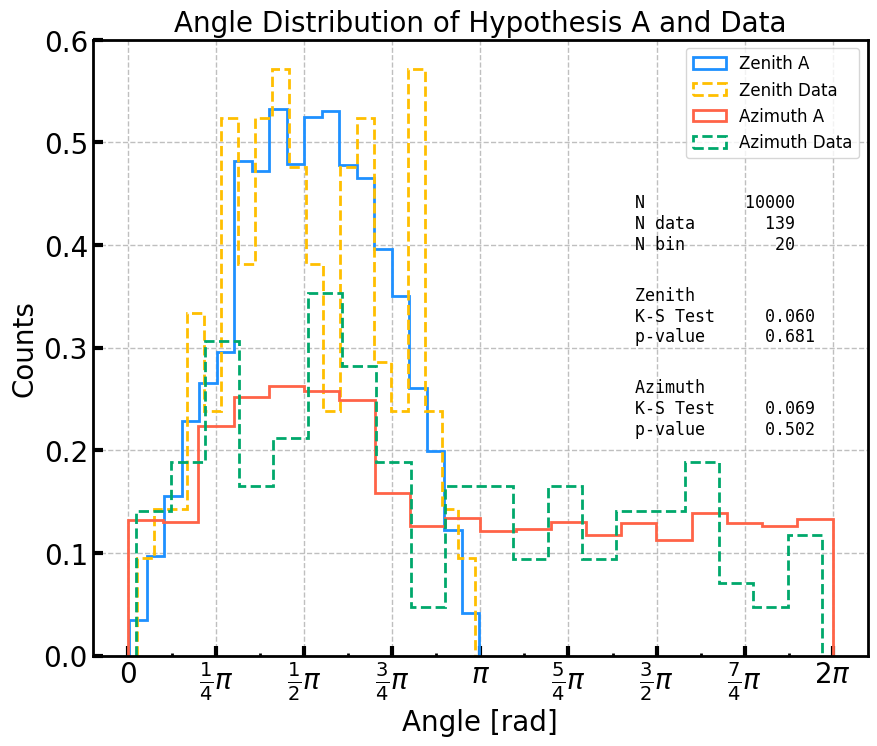

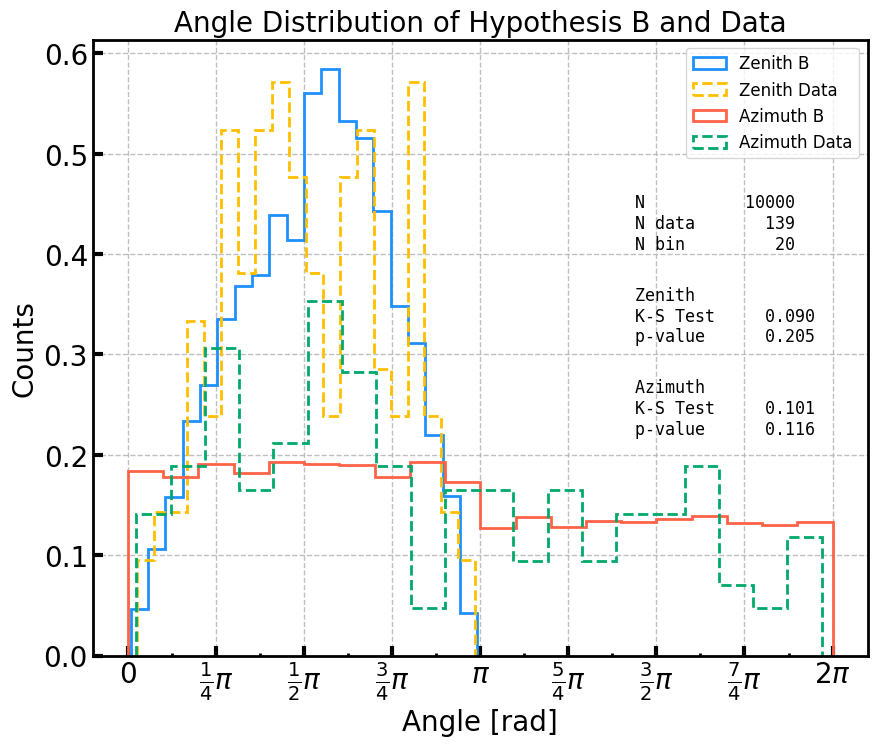

In [13]:
plotHisto(zenith1, azimuth1, 'A')
plotHisto(zenith2, azimuth2, 'B')